In [1]:
from matplotlib import pyplot as plt
import cv2
import numpy as np
from collections import defaultdict
import re
import os

In [2]:
def find_maxoverlap_offset(img1, img2):
    maxxoffset = None
    maxyoffset = None
    maxoverlap = 0
    for offsetx in range(-100, 100):
        for offsety in range(-100, 100):
            # Create a purely translational matrix
            M = np.array([[1, 0, offsetx],
                                           [0, 1, offsety]], dtype=np.float32)
            img2_t = cv2.warpAffine(img2, M, (img2.shape[1], img2.shape[0]))

            bitwiseand = cv2.bitwise_and(img1, img2_t)
            total = img1 + img2_t
            total_pixels = total[total > 0].shape[0]
            matches = bitwiseand[bitwiseand > 0].shape[0]
            percentage = (100 * matches / total_pixels)
            if percentage >= maxoverlap:
                maxoverlap = percentage
                maxxoffset = offsetx
                maxyoffset = offsety

    return maxoverlap, (maxxoffset, maxyoffset)

In [3]:
def display(img1_full, img1_gray, img2_full, img2_gray, show=False):

    blue_tinted_image = np.zeros_like(img1_full)
    blue_tinted_image[:, :, 2] = img1_gray
    red_tinted_image = np.zeros_like(img2_full)
    red_tinted_image[:, :, 0] = img2_gray

    overlay = cv2.addWeighted(blue_tinted_image, 0.5, red_tinted_image, 0.5, 0)

    if show:
        plt.figure(figsize=(24,12))
        plt.subplot(1,1,1); plt.imshow(overlay); plt.title("Overlay after alignment")
        plt.show()

    return overlay

In [4]:
def group_and_order_filenames(filenames, maxTP, maxLevel):
    grouped_files = defaultdict(lambda: defaultdict(lambda: [None] * maxTP))
    pattern = r'^(?P<plant>[^_]+)_(?P<tube>\d+)_(?P<level>\d+)_(?P<date>\d{4}-\d{2}-\d{2})_TP(?P<timepoint>\d+)\.png$'
    #plant_tube_depth_yyyy-mm-dd_TP#

    for fname in filenames:

        match = re.match(pattern, fname)
        if match:
            plant = match.group('plant')
            tube = int(match.group('tube'))
            level = int(match.group('level'))
            date = match.group('date')
            timepoint = int(match.group('timepoint'))
            if 1 <= timepoint <= maxTP:
                grouped_files[tube][level - 1][timepoint - 1] = fname

    return grouped_files

In [5]:
def register(img1_full, img2_full):
    img1_gray = cv2.cvtColor(img1_full, cv2.COLOR_BGR2GRAY)
    img2_gray = cv2.cvtColor(img2_full, cv2.COLOR_BGR2GRAY)

    # Define a threshold value
    # Pixels with intensity above this value will be white (255), otherwise black (0)
    img1_gray = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8)).apply(img1_gray)
    img2_gray = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8)).apply(img2_gray)
    threshold_value = 127

    # Apply binary thresholding
    # ret is the optimal threshold value if using methods like OTSU, but for simple binary, it's just the threshold_value
    ret1, img1_binary = cv2.threshold(img1_gray, threshold_value, 255, cv2.THRESH_BINARY)
    ret2, img2_binary = cv2.threshold(img2_gray, threshold_value, 255, cv2.THRESH_BINARY)

    # Find max correlation
    maxoverlap, (maxxoffset, maxyoffset) = find_maxoverlap_offset(img1_binary, img2_binary)
    # M = np.array([[1, 0, maxxoffset],
    #               [0, 1, maxyoffset]], dtype=np.float32)
    # img2_t = cv2.warpAffine(img2_full, M, (img2_full.shape[1], img2_full.shape[0]))
    # img2_t_gray = cv2.cvtColor(img2_t, cv2.COLOR_BGR2GRAY)
    #
    # overlay = display(img1_full, img1_gray, img2_t, img2_t_gray)
    # return img2_t, overlay
    return (maxxoffset, maxyoffset)

In [6]:
def pipeline(fname1, fname2):
    img1 = cv2.imread(fname1)    # reference (earlier)
    img2 = cv2.imread(fname2)      # moving (later)
    result = register(img1, img2)

    if result is not None:
        # aligned_full, overlay = result
        # filename_without_extension, file_extension = os.path.splitext(fname2)
        # cv2.imwrite(filename_without_extension + "_correlate.png", aligned_full)
        # cv2.imwrite(filename_without_extension + "_correlate_overlay.png", overlay)
        return result
    else:
        return False

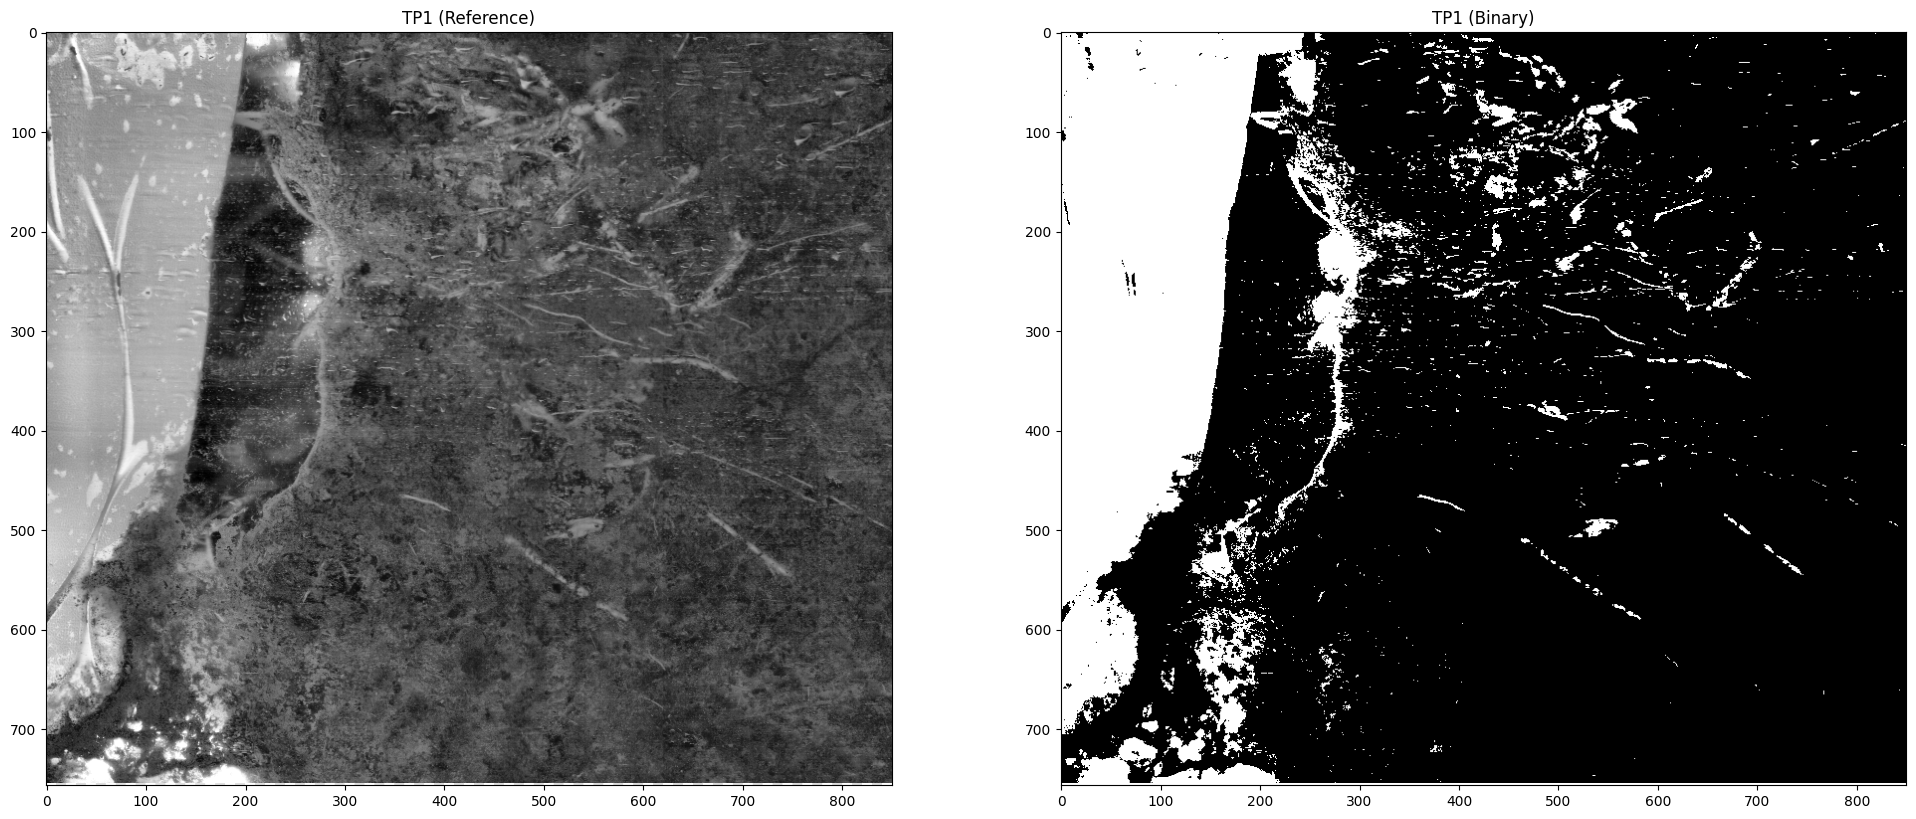

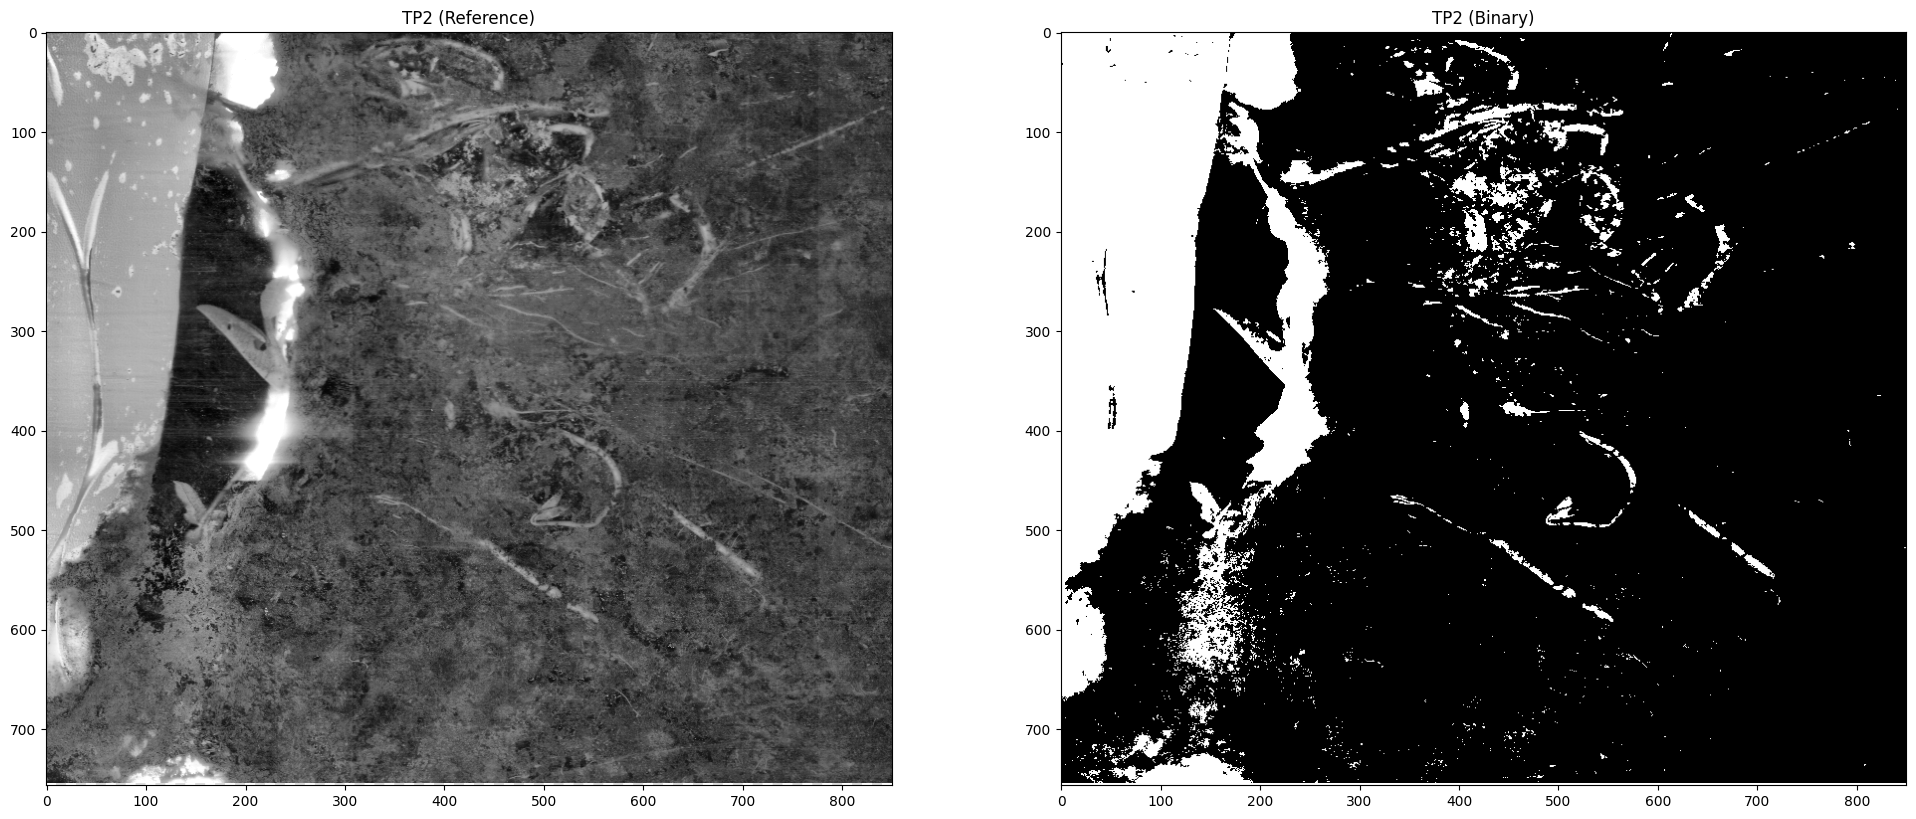

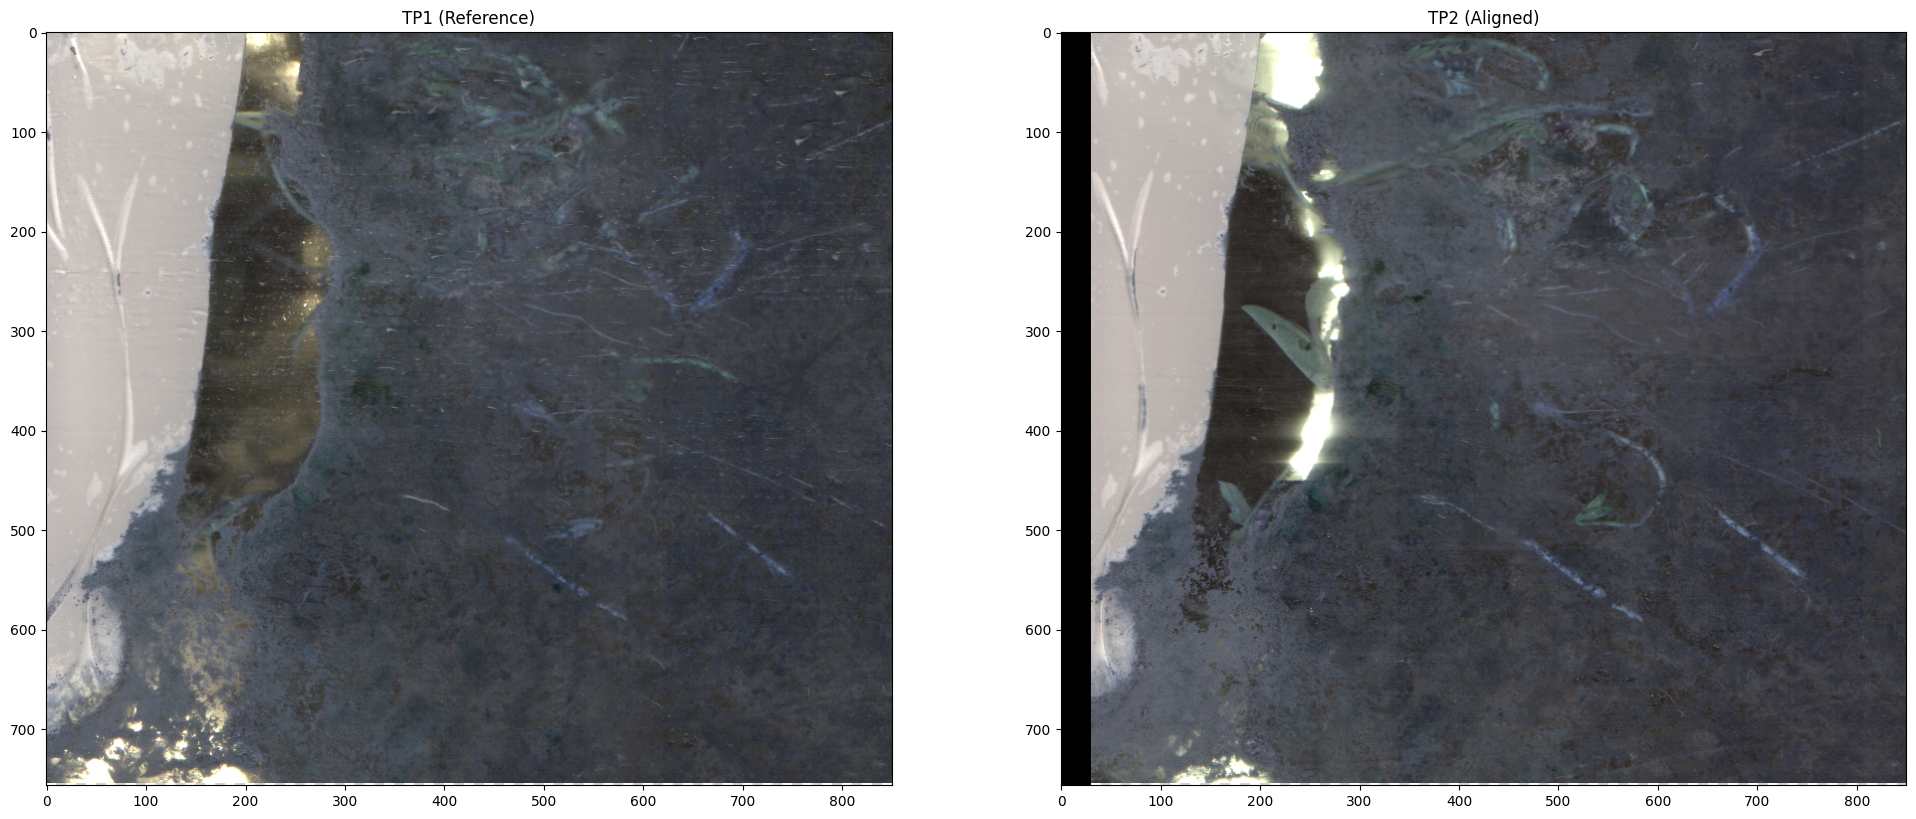

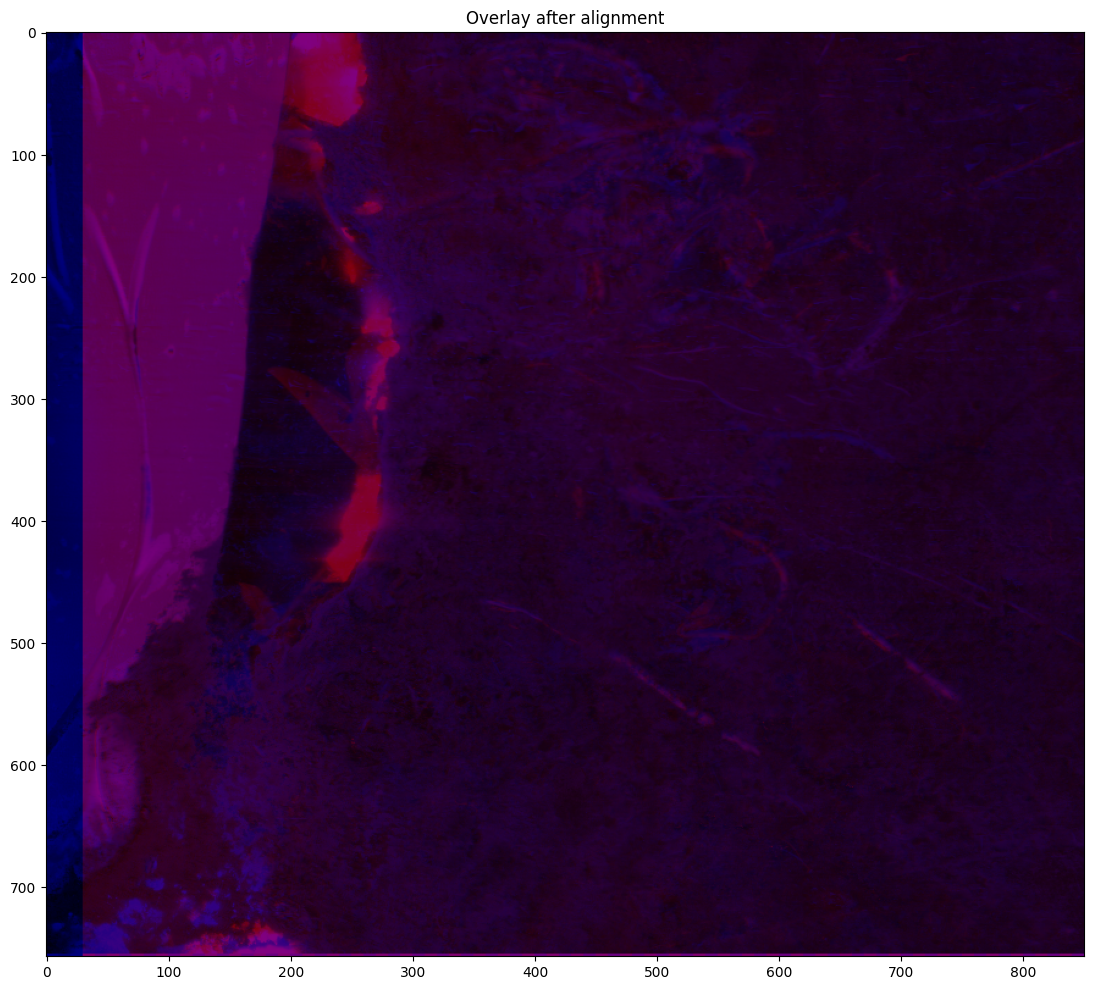

In [7]:
# Load the image in grayscale
# i1_path = 'slu_data/201/kura_201_001_2024-03-11_TP1.png'
# i2_path = 'slu_data/201/kura_201_001_2024-03-26_TP2.png'
i1_path = 'slu_data/kura_201_001_2024-04-09_TP3.png'
i2_path = 'slu_data/kura_201_1_2024-04-22_TP4.png'
img1_full = cv2.imread(i1_path)
img2_full = cv2.imread(i2_path)

if img1_full is None or img2_full is None:
    print(f"Error: Could not load images")
else:
    img1_gray = cv2.cvtColor(img1_full, cv2.COLOR_BGR2GRAY)
    img2_gray = cv2.cvtColor(img2_full, cv2.COLOR_BGR2GRAY)

    # Define a threshold value
    # Pixels with intensity above this value will be white (255), otherwise black (0)
    img1_gray = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8)).apply(img1_gray)
    img2_gray = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8)).apply(img2_gray)
    threshold_value = 127

    # Apply binary thresholding
    # ret is the optimal threshold value if using methods like OTSU, but for simple binary, it's just the threshold_value
    ret1, img1_binary = cv2.threshold(img1_gray, threshold_value, 255, cv2.THRESH_BINARY)
    ret2, img2_binary = cv2.threshold(img2_gray, threshold_value, 255, cv2.THRESH_BINARY)

    # Display the original and binary mask images

    plt.figure(figsize=(24,12))
    plt.subplot(1,2,1); plt.imshow(img1_gray, cmap='gray'); plt.title("TP1 (Reference)")
    plt.subplot(1,2,2); plt.imshow(img1_binary, cmap='gray'); plt.title("TP1 (Binary)")
    plt.show()

    plt.figure(figsize=(24,12))
    plt.subplot(1,2,1); plt.imshow(img2_gray, cmap='gray'); plt.title("TP2 (Reference)")
    plt.subplot(1,2,2); plt.imshow(img2_binary, cmap='gray'); plt.title("TP2 (Binary)")
    plt.show()

    # Find max correlation
    maxoverlap, (maxxoffset, maxyoffset) = find_maxoverlap_offset(img1_binary, img2_binary)
    M = np.array([[1, 0, maxxoffset],
                               [0, 1, maxyoffset]], dtype=np.float32)
    img2_t = cv2.warpAffine(img2_full, M, (img2_full.shape[1], img2_full.shape[0]))
    img2_t_gray = cv2.cvtColor(img2_t, cv2.COLOR_BGR2GRAY)

    # Display the result

    plt.figure(figsize=(24,12))
    plt.subplot(1,2,1); plt.imshow(img1_full, cmap='gray'); plt.title("TP1 (Reference)")
    plt.subplot(1,2,2); plt.imshow(img2_t, cmap='gray'); plt.title("TP2 (Aligned)")
    plt.show()

    display(img1_full, img1_gray, img2_t, img2_t_gray, show=True)

In [8]:
def accumulate(filename, translation, translations, references, all):
    if filename not in references:
        return translation

    ref = references[filename]
    if ref not in translations or ref not in all:
        ref_translation = (0,0)
        return tuple(map(sum, zip(translation, ref_translation)))
    else:
        ref_translation = translations[ref]
        all.remove(ref)
        return tuple(map(sum, zip(translation, accumulate(ref, ref_translation, translations, references, all))))

In [9]:
imgfilelist = [f for f in os.listdir("slu_data") if f.endswith(".png")]
print(f"Found {len(imgfilelist)} image files")

imgfilegroups = group_and_order_filenames(imgfilelist, 12, 7)
print(f"Found {len(imgfilelist)} image groups")

Found 12 image files
Found 12 image groups


In [12]:
for tube, depths in imgfilegroups.items():
    for depth, tp_files in depths.items():

        non_none_files = list(filter(None, tp_files))
        my_iterator = iter(non_none_files)
        translations = {}
        references = {}
        try:

            current_item = next(my_iterator)
            next_item = next(my_iterator)
            translations[current_item] = (0,0)
            while current_item and next_item:

                current_without_extension, current_extension = os.path.splitext(current_item)
                next_path = "slu_data/" + next_item
                current_path = "slu_data/" + current_item
                translation = pipeline(current_path, next_path)
                if translation:
                    translations[next_item] = translation
                    references[next_item] = current_item

                current_item = next_item
                next_item = next(my_iterator)

        except StopIteration:

            global_translations = {}
            for f_accumulate, t_accumulate in translations.items():
                try:
                    all_compared = non_none_files.copy()
                    global_t = accumulate(f_accumulate, t_accumulate, translations, references, all_compared)
                    global_translations[f_accumulate] = global_t
                except RecursionError:
                    print("f_accumulate: " + f_accumulate)

            global_x = [x for (dx, dy) in global_translations.values() for x in (dx, dx + 850)]
            global_y = [y for (dx, dy) in global_translations.values() for y in (dy, dy + 757)]
            min_x = min(global_x)
            min_y = min(global_y)
            max_x = max(global_x)
            max_y = max(global_y)
            final_cols  = max_x - min_x
            final_rows = max_y - min_y
            offset_x = -min_x
            offset_y = -min_y

            for f, t in global_translations.items():
                f_no_ext, f_ext = os.path.splitext(f)
                p = "slu_data/" + f
                img = cv2.imread(p)

                c_start = t[0] + offset_x
                r_start = t[1] + offset_y
                new_img = np.zeros((final_rows, final_cols, 3), dtype=img.dtype)

                try:
                    new_img[r_start:r_start + img.shape[0], c_start:c_start + img.shape[1]] = img
                except ValueError:
                    print("f: " + f)

                cv2.imwrite("slu_data/" + f_no_ext + "_correlate.png", new_img)

            for f_overlay, r_overlay in references.items():
                f_no_ext, f_ext = os.path.splitext(f_overlay)
                if os.path.exists("slu_data/" + f_no_ext + "_correlate.png"):
                    f_path = "slu_data/" + f_no_ext + "_correlate.png"
                else:
                    f_path = "slu_data/" + f_overlay
                r_no_ext, r_ext = os.path.splitext(r_overlay)
                if os.path.exists("slu_data/" + r_no_ext + "_correlate.png"):
                    r_path = "slu_data/" + r_no_ext + "_correlate.png"
                else:
                    r_path = "slu_data/" + r_overlay

                img_f = cv2.imread(f_path)
                img_r = cv2.imread(r_path)
                img_f_gray = cv2.cvtColor(img_f, cv2.COLOR_BGR2GRAY)
                img_r_gray = cv2.cvtColor(img_r, cv2.COLOR_BGR2GRAY)
                img_f_gray = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8)).apply(img_f_gray)
                img_r_gray = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8)).apply(img_r_gray)
                f_overlay = display(img_r, img_r_gray, img_f, img_f_gray)
                cv2.imwrite("slu_data/" + f_no_ext + "_correlate_overlay.png", f_overlay)

            continue